In [196]:
import sys
import os
import json
import pickle
import shutil
import numpy as np
import pandas as pd
import imageio

class SingleShot(object):
    """docstring for singleShot"""
    def __init__(self, id,
                 origRGB_dir, json_dir, rawBMPs_dirs, CSVfull_dir, 
                 CSVcrop_dir, CSVspec_dir, RGBwithPOV_dir, BMPwithPOV_dir):
        self.id       = id
        
        self.origRGB_dir      = origRGB_dir
        self.json_dir         = json_dir
        self.rawBMPs_dirs     = rawBMPs_dirs 
        self.numBMPs          = len(self.rawBMPs_dirs) if self.rawBMPs_dirs else 0
        if len(self.rawBMPs_dirs) > 0:
            self.rawBMPs_dirs = ["{}_{}.bmp".format(os.path.join(os.path.dirname(self.rawBMPs_dirs[0]),self.id),integer) for integer in sorted([int(tmp.split('_')[-1].split('.')[0]) for tmp in self.rawBMPs_dirs])]
        self.CSVcrop_dir    = CSVcrop_dir
        self.CSVfull_dir    = CSVfull_dir
        self.CSVspec_dir    = CSVspec_dir
        self.RGBwithPOV_dir = RGBwithPOV_dir
        self.BMPwithPOV_dir = BMPwithPOV_dir
        
        self.jsonDic = None
        if self.json_dir != None:
            if os.path.isfile(self.json_dir):
                file = open(self.json_dir, 'r', encoding = 'utf-8')
                self.jsonDic = json.loads(file.read())
                file.close()
#     def getReflection(self):
    def get_spectrum(self, filename, startpixel, endpixel, outputfile = None):
        try:
            img = imageio.imread(filename)
        except:
            print("error image reading")

        if img.shape == (640, 480, 3):                  #for RGB bmp file (wihth blue/red lines)
            tmp = img[startpixel:endpixel, :, 0]        #assuming 3 channels are equal ,(so I'm only using the red channel)
        else:
            tmp = img[startpixel:endpixel, :]           #for mono bmp file (without blue/red lines)
        tmp = np.mean(tmp, 0)

        if outputfile != None:
            np.savetxt(outputfile, tmp, delimiter=',')
            print('saved as \"', outputfile, '\"')
        return tmp



In [188]:
class SetFormatter():
    def __init__(self, directory, typeDictionary = None, from_gry = False):
        self.dir = directory
        self.dir_pcGen = os.path.join(self.dir, 'pcGen')
        self.dir_pickle = os.path.join(self.dir, 'pcGen', 'dir_pickle.gry')
        self.dir_pcGen_ref = os.path.join(self.dir, 'pcGen', 'reflection.gry')
        if not from_gry:
            self.Types = {}          #mostly associated with the downloading types
            self.usingTypes = {}     #mostly associated with the types you want to use in your work
            self.allFnames = {}
            self.setWhichTypes(typeDictionary)
            self.checkFiles()
            self.usingUniqueID_inSeperateBuckets = []
            self.numShots = 0
            self.shots = []
            self.ratio = pd.read_csv("ratio.csv")

            self.from_webGen  = 0
            self.from_rawBMPs = 1
        else:
            self.load(self.dir_pickle)
        
    def setWhichTypes(self, tmpdict):
        self.Types['origRGB']    = tmpdict['origRGB']    if ("origRGB"    in tmpdict) else False
        self.Types['json']       = tmpdict['json']       if ("json"       in tmpdict) else False
        self.Types['rawBMPs']    = tmpdict['rawBMPs']    if ("rawBMPs"    in tmpdict) else False
        self.Types['CSVfull']    = tmpdict['CSVfull']    if ("CSVfull"    in tmpdict) else False
        self.Types['CSVcrop']    = tmpdict['CSVcrop']    if ("CSVcrop"    in tmpdict) else False
        self.Types['CSVspec']    = tmpdict['CSVspec']    if ("CSVspec"    in tmpdict) else False
        self.Types['RGBwithPOV'] = tmpdict['RGBwithPOV'] if ("RGBwithPOV" in tmpdict) else False
        self.Types['BMPwithPOV'] = tmpdict['BMPwithPOV'] if ("BMPwithPOV" in tmpdict) else False
        
    def dir_origRGB(self, ID):
        os.path.join(directory, '{}.jpg'.format(ID))
    def dir_json(self, ID):
        os.path.join(directory, '{}.json'.format(ID))
    def dir_rawBMPs(self, ID, i_th):
        os.path.join(directory, 'rawBMPs', '{}_{}.bmp'.format(ID,i_th))
    def dir_CSVfull(self, ID):
        os.path.join(directory, 'webGen', '{}_full.csv'.format(ID))
    def dir_CSVcrop(self, ID):
        os.path.join(directory, 'webGen', '{}_crop.csv'.format(ID))
    def dir_CSVspec(self, ID):
        os.path.join(directory, 'webGen', '{}_spec_NDVI.csv'.format(ID))
    def dir_RGBwithPOV(self, ID):
        os.path.join(directory, 'webGen', '{}.jpeg'.format(ID))
    def dir_BMPwithPOV(self, ID):
        os.path.join(directory, 'webGen', '{}.png'.format(ID))
    
    def checkFiles(self):
        self.allFnames['origRGB']    = [s for s in os.listdir(self.dir) if os.path.isfile(os.path.join(self.dir, s)) and '.jpg' in s]
        self.allFnames['json']       = [s for s in os.listdir(self.dir) if os.path.isfile(os.path.join(self.dir, s)) and '.json' in s]
        self.allFnames['rawBMPs']    = [s for s in os.listdir(os.path.join(self.dir,'rawBMPs')) if os.path.isfile(os.path.join(self.dir,'rawBMPs',s)) and '.bmp'           in s]
        self.allFnames['CSVfull']    = [s for s in os.listdir(os.path.join(self.dir, 'webGen')) if os.path.isfile(os.path.join(self.dir, 'webGen',s)) and '_full.csv'      in s]
        self.allFnames['CSVcrop']    = [s for s in os.listdir(os.path.join(self.dir, 'webGen')) if os.path.isfile(os.path.join(self.dir, 'webGen',s)) and '_crop.csv'      in s]
        self.allFnames['CSVspec']    = [s for s in os.listdir(os.path.join(self.dir, 'webGen')) if os.path.isfile(os.path.join(self.dir, 'webGen',s)) and '_spec_NDVI.csv' in s]
        self.allFnames['RGBwithPOV'] = [s for s in os.listdir(os.path.join(self.dir, 'webGen')) if os.path.isfile(os.path.join(self.dir, 'webGen',s)) and '.jpeg'          in s]
        self.allFnames['BMPwithPOV'] = [s for s in os.listdir(os.path.join(self.dir, 'webGen')) if os.path.isfile(os.path.join(self.dir, 'webGen',s)) and '.png'           in s]
    
        self.allFnames['origRGB'].sort()
        self.allFnames['json'].sort()
        self.allFnames['rawBMPs'].sort()
        self.allFnames['CSVfull'].sort()
        self.allFnames['CSVcrop'].sort()
        self.allFnames['CSVspec'].sort()
        self.allFnames['RGBwithPOV'].sort()
        self.allFnames['BMPwithPOV'].sort()
    def cleanFiles(self):
        for s in os.listdir(self.dir):
            ss = os.path.join(self.dir, s)

            if os.path.isfile(ss):
                if not (s in self.allFnames['origRGB'] or 
                        s in self.allFnames['json']):
                    print("removed file:", s)
                    os.remove(ss)
            if os.path.isdir(ss):
                if (not s == "rawBMPs") and (not s == "webGen"):
                    shutil.rmtree(ss)
                    print("removed directory:", s)
                    
        tmpdir = os.path.join(self.dir, 'rawBMPs')
        for s in os.listdir(tmpdir):
            ss = os.path.join(tmpdir, s)
            if os.path.isfile(ss):
                if not (s in self.allFnames['rawBMPs']):
                    print("removed file: rawBMPs/", s)
                    os.remove(ss)                
            if os.path.isdir(ss):
                shutil.rmtree(ss)
                print("removed directory: rawBMPs/", s) 
        
        tmpdir = os.path.join(self.dir, 'webGen')
        for s in os.listdir(tmpdir):
            ss = os.path.join(tmpdir, s)
            if os.path.isfile(ss):
                if not (s in self.allFnames['CSVfull'] or 
                        s in self.allFnames['CSVcrop'] or 
                        s in self.allFnames['CSVspec'] or 
                        s in self.allFnames['RGBwithPOV'] or 
                        s in self.allFnames['BMPwithPOV']):
                    print("removed file: webGen/", s)
                    os.remove(ss)                
            if os.path.isdir(ss):
                shutil.rmtree(ss)
                print("removed directory: webGen/", s) 
    def read_ids(self, tmpdict, display = False):
        self.usingTypes['origRGB']    = tmpdict['origRGB']    if ("origRGB"    in tmpdict) else False
        self.usingTypes['json']       = tmpdict['json']       if ("json"       in tmpdict) else False
        self.usingTypes['rawBMPs']    = tmpdict['rawBMPs']    if ("rawBMPs"    in tmpdict) else False
        self.usingTypes['CSVfull']    = tmpdict['CSVfull']    if ("CSVfull"    in tmpdict) else False
        self.usingTypes['CSVcrop']    = tmpdict['CSVcrop']    if ("CSVcrop"    in tmpdict) else False
        self.usingTypes['CSVspec']    = tmpdict['CSVspec']    if ("CSVspec"    in tmpdict) else False
        self.usingTypes['RGBwithPOV'] = tmpdict['RGBwithPOV'] if ("RGBwithPOV" in tmpdict) else False
        self.usingTypes['BMPwithPOV'] = tmpdict['BMPwithPOV'] if ("BMPwithPOV" in tmpdict) else False
        
        self.usingUniqueID_inSeperateBuckets = []  #unique IDs over all set files (in seperate in their file types)
        if self.usingTypes['origRGB']:
            self.usingUniqueID_inSeperateBuckets.append([fname.split('.')[0]  for fname in self.allFnames['origRGB']])
            print(("origRGB   :unique count: {}\n".format(len(self.usingUniqueID_inSeperateBuckets[-1])) if display else ''),  end='')
        if self.usingTypes['json']:
            self.usingUniqueID_inSeperateBuckets.append([fname.split('.')[0]  for fname in self.allFnames['json']])
            print(("json      :unique count: {}\n".format(len(self.usingUniqueID_inSeperateBuckets[-1])) if display else ''),  end='')
        if self.usingTypes['CSVfull']:
            self.usingUniqueID_inSeperateBuckets.append([fname.split('_')[0] + '_'+ fname.split('_')[1]  for fname in self.allFnames['CSVfull']])
            print(("CSVfull   :unique count: {}\n".format(len(self.usingUniqueID_inSeperateBuckets[-1])) if display else ''),  end='')
        if self.usingTypes['CSVcrop']:
            self.usingUniqueID_inSeperateBuckets.append([fname.split('_')[0] + '_'+ fname.split('_')[1]  for fname in self.allFnames['CSVcrop']])
            print(("CSVcrop   :unique count: {}\n".format(len(self.usingUniqueID_inSeperateBuckets[-1])) if display else ''),  end='')
        if self.usingTypes['CSVspec']:
            self.usingUniqueID_inSeperateBuckets.append([fname.split('_')[0] + '_'+ fname.split('_')[1]  for fname in self.allFnames['CSVspec']])
            print(("CSVspec   :unique count: {}\n".format(len(self.usingUniqueID_inSeperateBuckets[-1])) if display else ''),  end='')
        if self.usingTypes['RGBwithPOV']:
            self.usingUniqueID_inSeperateBuckets.append([fname.split('.')[0]  for fname in self.allFnames['RGBwithPOV']])
            print(("RGBwithPOV:unique count: {}\n".format(len(self.usingUniqueID_inSeperateBuckets[-1])) if display else ''),  end='')
        if self.usingTypes['BMPwithPOV']:
            self.usingUniqueID_inSeperateBuckets.append([fname.split('.')[0]  for fname in self.allFnames['BMPwithPOV']])
            print(("BMPwithPOV:unique count: {}\n".format(len(self.usingUniqueID_inSeperateBuckets[-1])) if display else ''),  end='')
        if self.usingTypes['rawBMPs']:
            self.usingUniqueID_inSeperateBuckets.append(list(set([fname.split('_')[0] + '_'+ fname.split('_')[1]  for fname in self.allFnames['rawBMPs']])))
            print(("rawBMPs   :unique count: {}\n".format(len(self.usingUniqueID_inSeperateBuckets[-1])) if display else ''),  end='')
            #self.usingUniqueID_inSeperateBuckets.append([fname.split('.')[0]  for fname in self.allFnames['rawBMPs']])
            #since rawBMPs have multiple files in a single shot, and I want only ID's so I did following
        
        #now calculating unique IDs over all set of files
        print(("============================\n" if display else ''),  end='')

        self.usingUniqueIDs = []
        Tmp = len(self.usingUniqueID_inSeperateBuckets)
        for i in range(len(self.usingUniqueID_inSeperateBuckets[0])):
            tmpID = self.usingUniqueID_inSeperateBuckets[0][i]
            tmpbool = True
            for t in range(1,Tmp):
                tmpbool = tmpbool and (tmpID in self.usingUniqueID_inSeperateBuckets[t])
                if not tmpbool:
                    print(("- incomplete shot: {} has no {}\n".format(tmpID, list(tmpdict.keys())[t]) if display else ''),  end='')
                    break
            if tmpbool:
                self.usingUniqueIDs.append(tmpID)
           
        self.usingUniqueIDs.sort()
        self.numShots = len(self.usingUniqueIDs)
        print(("==============================================\nIn Given types, {} unique shots in this Set.\n".format(self.numShots) if display else ''),  end='')
        
        
        for i in range(self.numShots):
            tmpid       = self.usingUniqueIDs[i]
            tmp_dirorigRGB = os.path.join(self.dir,  '{}.jpg'.format(tmpid)) if self.usingTypes['origRGB']    else None
            tmp_dirjson    = os.path.join(self.dir, '{}.json'.format(tmpid)) if self.usingTypes['json']       else None
            tmp_dirrawBMPs = [(os.path.join(sf.dir,'rawBMPs', fnamebmps)) for fnamebmps in os.listdir(os.path.join(sf.dir,'rawBMPs')) if tmpid in fnamebmps] 

            #tmp_dirrawBMPs = os.path.join(self.dir,'rawBMPs', '{}.jpeg'.format(tmpid)) if self.usingTypes['rawBMPs']    else None
            tmp_dirCSVfull = os.path.join(self.dir,'webGen',  '{}_full.csv'.format(tmpid)) if self.usingTypes['CSVfull']    else None
            tmp_dirCSVcrop = os.path.join(self.dir,'webGen',  '{}_crop.csv'.format(tmpid)) if self.usingTypes['CSVcrop']    else None
            tmp_dirCSVspec = os.path.join(self.dir,'webGen',  '{}_spec_NDVI.csv'.format(tmpid)) if self.usingTypes['CSVspec']    else None
            tmp_RGBwithPOV = os.path.join(self.dir,'webGen',  '{}.jpeg'.format(tmpid)) if self.usingTypes['RGBwithPOV'] else None
            tmp_BMPwithPOV = os.path.join(self.dir,'webGen',   '{}.png'.format(tmpid)) if self.usingTypes['BMPwithPOV'] else None
            self.shots.append(SingleShot(id             = tmpid,
                                         origRGB_dir    = tmp_dirorigRGB, 
                                         json_dir       = tmp_dirjson, 
                                         rawBMPs_dirs   = tmp_dirrawBMPs, 
                                         CSVfull_dir    = tmp_dirCSVfull, 
                                         CSVcrop_dir    = tmp_dirCSVcrop,
                                         CSVspec_dir    = tmp_dirCSVspec,
                                         RGBwithPOV_dir = tmp_RGBwithPOV,
                                         BMPwithPOV_dir = tmp_BMPwithPOV,
                                        ))
    def mkdir_pcGen(self):
        if not (os.path.isdir(self.dir_pcGen)):
            os.mkdir(self.dir_pcGen)
            
    def compose_pcGen_setWave(self, source, display = False):
        self.mkdir_pcGen()
        if self.numShots == 0:
            print("None shots in the folder")
            return
        if (source == self.from_webGen):
            print(("Composing wavelengths from webGen\n" if display else ''), end = '')
            self.setWave = np.zeros((self.numShots, 1,280))
            for i in range(self.numShots):
                tmpPdWeb = pd.read_csv(self.shots[i].CSVfull_dir)
                self.setWave[i,0,:]  = np.array(pd.read_csv(self.shots[i].CSVfull_dir)['WAVELENGTH'])
            np.save(os.path.join(self.dir_pcGen, 'setWave'), self.setWave)
            print(("Saved as pcGen/setWave.npy\n" if display else ''), end = '')
            return
        elif (source == self.from_rawBMPs):
            pass
        
    def compose_pcGen_setGray(self, source, display = False):
        self.mkdir_pcGen()
        if self.numShots == 0:
            print("None shots in the folder")
            return
        if (source == self.from_webGen):
            print(("Composing Gray pixel values from webGen\n" if display else ''), end = '')
            self.setGray = np.zeros((self.numShots, 1,280))
            for i in range(self.numShots):
                tmpPdWeb = pd.read_csv(self.shots[i].CSVfull_dir)
                self.setGray[i,0,:]  = np.array(pd.read_csv(self.shots[i].CSVfull_dir)['GRAY'])
            np.save(os.path.join(self.dir_pcGen, 'setGray'), self.setGray)
            print(("Saved as pcGen/setGray.npy\n" if display else ''), end = '')
            return
        elif (source == self.from_rawBMPs):
            pass
        else:
            print("Mistake: <source> wrong: source = ....from_webGen or ....from_rawBMPs")
            
    def compose_pcGen_setLeaf(self, source, display = False):
        self.mkdir_pcGen()
        if self.numShots == 0:
            print("None shots in the folder")
            return
        if (source == self.from_webGen):
            print(("Composing Leaf pixel values from webGen\n" if display else ''), end = '')
            self.setLeaf = np.zeros((self.numShots, 1,280))
            for i in range(self.numShots):
                tmpPdWeb = pd.read_csv(self.shots[i].CSVfull_dir)
                self.setLeaf[i,0,:]  = np.array(pd.read_csv(self.shots[i].CSVfull_dir)['LEAF'])
            np.save(os.path.join(self.dir_pcGen, 'setLeaf'), self.setLeaf)
            print(("Saved as pcGen/setLeaf.npy\n" if display else ''), end = '')
            return
        elif (source == self.from_rawBMPs):
            pass
        else:
            print("Mistake: <source> wrong: source = ....from_webGen or ....from_rawBMPs")
    
    def compose_pcGen_setMask(self, leafRange = [16,255], grayRange = [16,255], display = False):
        self.setGray = np.load(os.path.join(self.dir_pcGen, 'setGray.npy'))
        self.setLeaf = np.load(os.path.join(self.dir_pcGen, 'setLeaf.npy'))
        maskLeaf = np.logical_and(self.setLeaf >= leafRange[0], self.setLeaf <= leafRange[1])
        maskGray = np.logical_and(self.setGray >= grayRange[0], self.setGray <= grayRange[1])
        self.setMask  = np.logical_and(maskLeaf, maskGray)
        
        np.save(os.path.join(self.dir_pcGen, 'setMask'), self.setMask)
        print(("Saved as pcGen/setMask.npy\n" if display else ''), end = '')
#         self.setMask = np.logical_and(np.where())
        
    def compose_pcGen_setWhite(self, source, BG = 10.5, display = False):
        self.mkdir_pcGen()
        if self.numShots == 0:
            print("None shots in the folder")
            return
        if (source == self.from_webGen):
            print(("Composing Leaf pixel values from webGen\n" if display else ''), end = '')
            self.setWhite  = np.zeros((self.numShots,1, 280))
            for i in range(self.numShots):
                tmpPdWeb = pd.read_csv(self.shots[i].CSVfull_dir)
                tmpGray  = np.array(pd.read_csv(self.shots[i].CSVfull_dir)['GRAY'])
                self.setWhite[i,0,:] = (tmpGray-BG)/np.array(self.ratio['GRAY/WHITE'])+BG
            np.save(os.path.join(self.dir_pcGen, 'setWhite'), self.setWhite)
            print(("Saved as pcGen/setWhite.npy\n" if display else ''), end = '')
            return
        elif (source == self.from_rawBMPs):
            pass
        else:
            print("Mistake: <source> wrong: source = ....from_webGen or ....from_rawBMPs")
    
        
    def calcReflection(self,BG=10.5):
        self.setWhite = np.load(os.path.join(self.dir_pcGen, 'setWhite.npy'))
        self.setLeaf  = np.load(os.path.join(self.dir_pcGen, 'setLeaf.npy'))
        self.setWave  = np.load(os.path.join(self.dir_pcGen, 'setWave.npy'))
        if not(self.setWhite.shape == self.setLeaf.shape):
            print("Err: shape of setWhite and setLeaf are not equal")
            return
        self.numSection = self.setLeaf.shape[1]
        self.Reflection = []
        for i in range(self.numShots):
            self.Reflection.append({})
        for i in range(self.numShots):
            for s in range(self.numSection):
                tmpUsablePixelnum = np.sum(sf.setMask[i,s,:])
                tmp = np.zeros((tmpUsablePixelnum, 2))
#                 for j in range(tmpUsablePixelnum):
                tmp[:,0] = self.setWave[i,s,:][self.setMask[i,s,:]]
                tmp[:,1] = (self.setLeaf[i,s,:][self.setMask[i,s,:]]-BG)/(self.setWhite[i,s,:][self.setMask[i,s,:]]-BG)
                self.Reflection[i]['section{}'.format(s)] = np.copy(tmp)
                self.Reflection[i]['section{}_wavelength'.format(s)] = np.copy(tmp[:,0])
                self.Reflection[i]['section{}_reflection'.format(s)] = np.copy(tmp[:,1])
#                 plt.plot(tmp[:,0], tmp[:,1])
#                 plt.show()
#         self.Reflection = [[]]*self.numShots
#         for i in range(self.numShots):
#             tmp = []
#             for s in range(self.numSection):
#                 tmpUsablePixelnum = np.sum(sf.setMask[i,s,:])
#                 tmp.append(self.setWave[i,s,:][self.setMask[i,s,:]])
#                 tmp.append((self.setLeaf[i,s,:][self.setMask[i,s,:]]-BG)/(self.setWhite[i,s,:][self.setMask[i,s,:]]-BG) )
#             self.Reflection[i]= tmp
    
        file = open(self.dir_pcGen_ref, 'wb')
        pickle.dump(self.Reflection, file)
        file.close()                
        
        
    def save(self):
        file = open(self.dir_pickle, 'wb')
        pickle.dump(self, file)
        file.close()                
    def load(self, _dir_):
        #         print(_dir_)
        file = open(self.dir_pickle, 'rb')
        tmp = pickle.load(file)
        self.__dict__ = tmp.__dict__
        #         print(type(tmp.__dict__))
        file.close()
        print('read from {}'.format(self.dir_pickle))

In [189]:
Types = {
    "origRGB"   : True,
    "json"      : True,
    "rawBMPs"   : True,
    "CSVfull"   : True,
    "CSVcrop"   : True,
    "CSVspec"   : True,
    "RGBwithPOV": True,
    "BMPwithPOV": True,
}
sf = SetFormatter('/home/garid/myGit/spectrumCatcher/spectrumCatcher/tests/dname1221/13h_', Types)
sf.read_ids(Types, display=True)

origRGB   :unique count: 326
json      :unique count: 326
CSVfull   :unique count: 326
CSVcrop   :unique count: 326
CSVspec   :unique count: 326
RGBwithPOV:unique count: 326
BMPwithPOV:unique count: 326
rawBMPs   :unique count: 326
- incomplete shot: 20191221_111708 has no json
In Given types, 325 unique shots in this Set.


In [190]:
# sf.cleanFiles()

In [191]:
sf.compose_pcGen_setWave(sf.from_webGen, True)
sf.compose_pcGen_setGray(sf.from_webGen, True)
sf.compose_pcGen_setLeaf(sf.from_webGen, True)
sf.compose_pcGen_setWhite(sf.from_webGen, BG=10.5,display=True)
sf.compose_pcGen_setMask(display = True)

Composing wavelengths from webGen
Saved as pcGen/setWave.npy
Composing Gray pixel values from webGen
Saved as pcGen/setGray.npy
Composing Leaf pixel values from webGen
Saved as pcGen/setLeaf.npy
Composing Leaf pixel values from webGen
Saved as pcGen/setWhite.npy
Saved as pcGen/setMask.npy


In [192]:
sf.ratio

,Unnamed: 0,PIXEL,WAVELENGTH,GRAY/WHITE
0,0,92,442.6,0.5002
1,1,93,444.8,0.4979
2,2,94,447.0,0.4958
3,3,95,449.2,0.4941
4,4,96,451.4,0.4927
...,...,...,...,...
275,275,367,1047.6,0.9287
276,276,368,1049.8,0.9287
277,277,369,1052.0,0.9287
278,278,370,1054.2,0.9287


In [193]:
sf.calcReflection()

In [275]:
sf.shots[12].rawBMPs_dirs

['/home/garid/myGit/spectrumCatcher/spectrumCatcher/tests/dname1221/13h_/rawBMPs/20191221_111735_0.bmp',
 '/home/garid/myGit/spectrumCatcher/spectrumCatcher/tests/dname1221/13h_/rawBMPs/20191221_111735_1.bmp',
 '/home/garid/myGit/spectrumCatcher/spectrumCatcher/tests/dname1221/13h_/rawBMPs/20191221_111735_2.bmp',
 '/home/garid/myGit/spectrumCatcher/spectrumCatcher/tests/dname1221/13h_/rawBMPs/20191221_111735_3.bmp',
 '/home/garid/myGit/spectrumCatcher/spectrumCatcher/tests/dname1221/13h_/rawBMPs/20191221_111735_5.bmp',
 '/home/garid/myGit/spectrumCatcher/spectrumCatcher/tests/dname1221/13h_/rawBMPs/20191221_111735_6.bmp',
 '/home/garid/myGit/spectrumCatcher/spectrumCatcher/tests/dname1221/13h_/rawBMPs/20191221_111735_7.bmp',
 '/home/garid/myGit/spectrumCatcher/spectrumCatcher/tests/dname1221/13h_/rawBMPs/20191221_111735_8.bmp',
 '/home/garid/myGit/spectrumCatcher/spectrumCatcher/tests/dname1221/13h_/rawBMPs/20191221_111735_10.bmp',
 '/home/garid/myGit/spectrumCatcher/spectrumCatcher/te

In [276]:
filename = sf.shots[12].rawBMPs_dirs[0]
img = imageio.imread(filename)

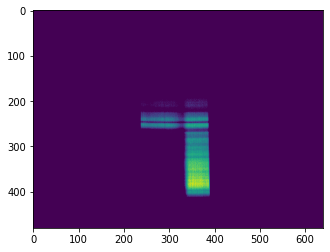

In [278]:
plt.imshow(img)


In [200]:
img.shape

(480, 640)

In [279]:
def get_spectrum(filename, startpixel, endpixel, outputfile = None):
    img = np.rot90(imageio.imread(filename), k = 3)
    tmp = img[startpixel:endpixel, :]           #for mono bmp file (without blue/red lines)
    tmp = np.mean(tmp, 0)

    if outputfile != None:
        np.savetxt(outputfile, tmp, delimiter=',')
        print('saved as \"', outputfile, '\"')
    return tmp

def grayToWhite(grayNarray):
	grayTowhiteRATIO = np.array([0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709,
       0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709,
       0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709,
       0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709,
       0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709,
       0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7708,
       0.7688, 0.7665, 0.764 , 0.7601, 0.7552, 0.7493, 0.7424, 0.7348,
       0.7261, 0.7162, 0.7056, 0.6944, 0.6829, 0.6712, 0.6595, 0.6479,
       0.6367, 0.6267, 0.6179, 0.6098, 0.603 , 0.5975, 0.5923, 0.5867,
       0.5812, 0.576 , 0.571 , 0.5661, 0.5614, 0.5569, 0.5526, 0.5479,
       0.5428, 0.5377, 0.5328, 0.5281, 0.5238, 0.5201, 0.5169, 0.5138,
       0.5109, 0.5083, 0.5055, 0.5028, 0.5002, 0.4979, 0.4958, 0.4941,
       0.4927, 0.4916, 0.4904, 0.4892, 0.4882, 0.487 , 0.4858, 0.4845,
       0.4834, 0.4824, 0.4812, 0.4802, 0.4792, 0.4781, 0.4768, 0.4754,
       0.474 , 0.4727, 0.4715, 0.4703, 0.4693, 0.4685, 0.4677, 0.467 ,
       0.4663, 0.4654, 0.4646, 0.4638, 0.4631, 0.4624, 0.4618, 0.4611,
       0.4604, 0.4595, 0.4586, 0.4577, 0.4568, 0.4559, 0.4551, 0.4542,
       0.4534, 0.4526, 0.452 , 0.4515, 0.4512, 0.4512, 0.4512, 0.4512,
       0.4513, 0.4514, 0.4516, 0.4519, 0.4521, 0.4522, 0.4522, 0.4521,
       0.4519, 0.4516, 0.4512, 0.4506, 0.45  , 0.4493, 0.4484, 0.4476,
       0.4468, 0.446 , 0.4454, 0.4448, 0.4443, 0.4439, 0.4436, 0.4434,
       0.4434, 0.4436, 0.4438, 0.4442, 0.4447, 0.4452, 0.4458, 0.4465,
       0.4472, 0.4478, 0.4485, 0.4492, 0.4499, 0.4506, 0.4514, 0.4522,
       0.4532, 0.4543, 0.4556, 0.4571, 0.4588, 0.4607, 0.4629, 0.4653,
       0.4679, 0.4706, 0.4737, 0.477 , 0.4808, 0.4848, 0.4889, 0.4932,
       0.4979, 0.5027, 0.5077, 0.5129, 0.5181, 0.5234, 0.529 , 0.5345,
       0.5401, 0.5455, 0.551 , 0.5565, 0.5622, 0.568 , 0.5737, 0.5792,
       0.5847, 0.5904, 0.5962, 0.602 , 0.6079, 0.6137, 0.6197, 0.6259,
       0.6323, 0.6388, 0.6455, 0.6522, 0.659 , 0.666 , 0.6729, 0.6799,
       0.687 , 0.6942, 0.7017, 0.7091, 0.7165, 0.724 , 0.7314, 0.739 ,
       0.7465, 0.754 , 0.7614, 0.7687, 0.776 , 0.7832, 0.7903, 0.7974,
       0.8044, 0.8112, 0.8178, 0.8242, 0.8303, 0.8362, 0.8417, 0.8469,
       0.8519, 0.8568, 0.8614, 0.8658, 0.8701, 0.8742, 0.8781, 0.8816,
       0.885 , 0.8882, 0.8913, 0.8942, 0.8968, 0.8991, 0.9012, 0.9033,
       0.9052, 0.9069, 0.9084, 0.9099, 0.9112, 0.9124, 0.9134, 0.9145,
       0.9156, 0.9165, 0.9174, 0.9182, 0.9189, 0.9196, 0.9204, 0.9212,
       0.922 , 0.9227, 0.9234, 0.9239, 0.9243, 0.9248, 0.9252, 0.9256,
       0.926 , 0.9264, 0.9267, 0.927 , 0.9272, 0.9274, 0.9275, 0.9277,
       0.9277, 0.9277, 0.9277, 0.9278, 0.9279, 0.928 , 0.9281, 0.9283,
       0.9284, 0.9286, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287])
	
	return (grayNarray - 16) / grayTowhiteRATIO + 16 


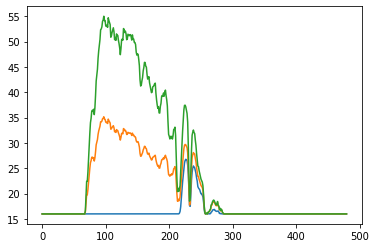

In [280]:
plt.plot(get_spectrum(filename, 237, 307))
plt.plot(get_spectrum(filename, 335, 365))
plt.plot(grayToWhite(get_spectrum(filename, 335, 365)))

SyntaxError: invalid syntax (<ipython-input-224-238be9fcbd2b>, line 4)

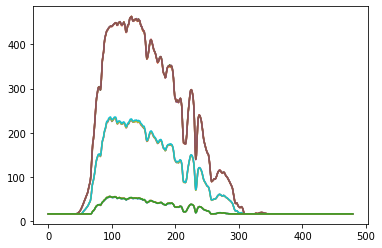

In [281]:
whites = []
for fname in sf.shots[12].rawBMPs_dirs:
    plt.plot(grayToWhite(get_spectrum(fname, 335, 365)))
    whites.append(grayToWhite(get_spectrum(fname, 335, 365)))

In [282]:
white = np.array(whites)

In [283]:
white.shape

(13, 480)

In [284]:
X = np.zeros((13, 480))
for i in range(13):
    X[i,:] = np.arange(480)

In [285]:
X[0,:]

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [286]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(white)
kmeans.labels_





array([0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0], dtype=int32)

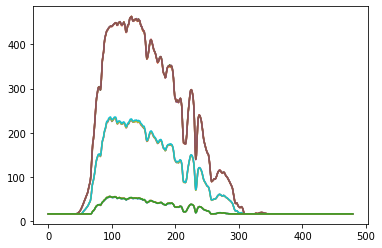

In [288]:
whites = []
for fname in sf.shots[12].rawBMPs_dirs:
    plt.plot(grayToWhite(get_spectrum(fname, 335, 365)))
    whites.append(grayToWhite(get_spectrum(fname, 335, 365)))

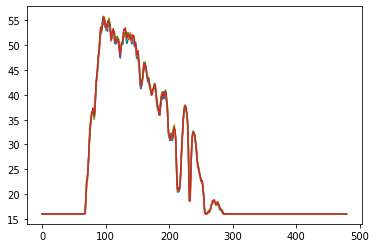

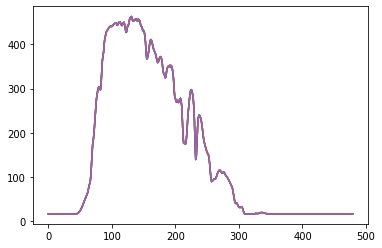

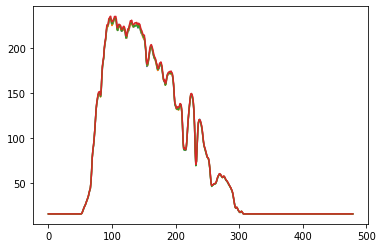

In [297]:
for i in range(white[kmeans.labels_==0, :].shape[0]):
    plt.plot(white[kmeans.labels_==0, :][i,:])
plt.show()
for i in range(white[kmeans.labels_==1, :].shape[0]):
    plt.plot(white[kmeans.labels_==1, :][i,:])
plt.show()
for i in range(white[kmeans.labels_==2, :].shape[0]):
    plt.plot(white[kmeans.labels_==2, :][i,:])
plt.show()

In [290]:
white.shape

(13, 480)

In [293]:
kmeans.labels_==0

array([ True, False, False, False, False, False, False, False, False,
       False,  True,  True,  True])